# TP1 : First order methods on regression models

#### Authors: A. Gramfort, R. Gower

## Aim

The aim of this material is to code 
- proximal gradient descent (ISTA)
- accelerated gradient descent (FISTA) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- ridge penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 8th of october at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 2 octobre 2017**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [130]:
# Change here using YOUR first and last names
fn1 = "xiangnan"
ln1 = "yue"
fn2 = "junfeng"
ln2 = "chen"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp1_yue_xiangnan_and_chen_junfeng.ipynb


In [131]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [132]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

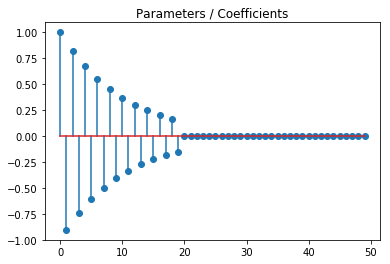

In [133]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

In [134]:
from scipy.linalg.special_matrices import toeplitz
corr=0.5
toeplitz(corr ** np.arange(0, 4))

array([[ 1.  ,  0.5 ,  0.25,  0.12],
       [ 0.5 ,  1.  ,  0.5 ,  0.25],
       [ 0.25,  0.5 ,  1.  ,  0.5 ],
       [ 0.12,  0.25,  0.5 ,  1.  ]])

### Functions for the simulation of the models

In [135]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b[:] = 2 * b - 1
    return A, b

## Part 1 : Proximal operators

We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(y, t) = \arg\min_x \Big\{ \frac 12 \|x - y\|_2^2 + t g(x) \Big\}.
$$

where $t \geq 0$ is a non-negative number.
We have in mind to use the following cases

- Ridge penalization, where $g(x) = \frac{s}{2} \|x\|_2^2$
- Lasso penalization, where $g(x) = s \|x\|_1$

where $s \geq 0$ is a regularization parameter.

## Questions

- Code a function that computes $g(x)$ in both cases and $\text{prox}_g(x)$ for ridge and  lasso penalization (use the slides of the first course to get the formulas), using the prototypes given below
- Visualize the functions applied element wise by the proximity operators of the Ridge and Lasso 

In [136]:
def prox_lasso(x, s, t=1.):
    """Proximal operator for the Lasso at x with strength t"""    
    return np.sign(x)*np.maximum(np.abs(x)-t*s, 0) # TODO
    
def lasso(x, s):
    """Value of the Lasso penalization at x with strength t"""
    return s*np.linalg.norm(x,ord=1) # TODO

def prox_ridge(x, s, t=1.):
    """Proximal operator for the ridge at x with strength t"""    
    return x/(1+s*t) # TODO
    
def ridge(x, s):
    """Value of the ridge penalization at x with strength t"""
    return s/2*np.linalg.norm(x,ord=2)**2 # TODO

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

(-2, 2)

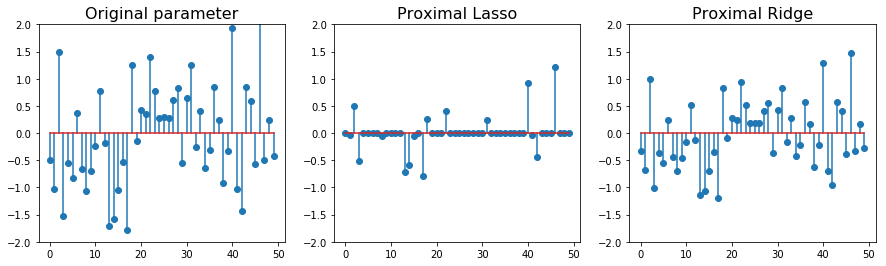

In [137]:
x = randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_lasso(x, s=l_l1, t=1))
plt.title("Proximal Lasso", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_ridge(x, s=l_l2,t=1))
plt.title("Proximal Ridge", fontsize=16)
plt.ylim([-2, 2])

## Question

- Comment what you observe (1 or 2 sentences).

## YOUR ANSWER HERE

The Proximal Lasso reduces the small x to 0 and cut the large x by a constant.
The proximal Ridge reduces the x by dividing it using a const > 1.

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + g(x)
$$
where $f$ is $L$-smooth and $g$ is prox-capable.

We will consider below the following cases

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A$ is the matrix of features.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(b_i - a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

**Questions**:
- Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)
- Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.
- Check that these functions are correct by numerically checking the gradient, using the function ``checkgrad`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model

In [138]:
A,b = simu_linreg(coefs=coefs)
A.T

array([[ 0.51,  1.45,  1.48, ...,  0.4 , -0.25,  1.09],
       [-0.96,  0.98,  0.05, ..., -0.63, -0.03,  1.2 ],
       [ 0.3 ,  1.17, -0.33, ..., -0.91, -1.29,  1.76],
       ..., 
       [-0.5 , -0.97,  0.35, ...,  0.67,  3.14,  0.16],
       [-1.66, -1.19,  0.51, ..., -1.81,  2.08,  1.35],
       [-0.89, -0.3 , -0.25, ..., -0.3 , -0.34,  1.17]])

In [139]:
np.shape(A)

(1000, 50)

In [140]:

def loss_linreg(x):
    """Least-squares loss"""
    # TODO
    n = len(x)
    return 1/(2*n) * np.linalg.norm(x=np.dot(A,x)-b, ord=2)**2

def grad_linreg(x):
    """Leas-squares gradient"""
    # TODO
    #A,b = simu_linreg(coefs=coefs)
    n = len(x)
    return 1/n * np.dot(A.T, np.dot(A,x)-b)

def loss_logreg(x):
    """Logistic loss"""
    # TODO
    #A,b = simu_logreg(coefs)
    n = len(x)
    return 1/n*np.sum(np.log(1 + np.exp(b - np.dot(A,x))))

def grad_logreg(x):
    """Logistic gradient"""
    # TODO
    #A,b = simu_logreg(coefs)
    n = len(x)
    temp = np.exp(b - np.dot(A,x))
    return -1/n*np.dot(A.T, temp/ (1 + temp))

# TO BE COMPLETED

In [233]:
#Check the gradient function
from scipy.optimize import check_grad
A,b = simu_linreg(coefs=coefs)
x =np.random.randn(50)
check_grad(loss_linreg, grad_linreg, x) / np.linalg.norm(grad_linreg(x),ord=2)

3.5311304659609547e-07

## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $g$ and $\text{prox}_g$. 

We want now to code the Ista and Fista solvers to minimize

$$
\arg\min_x f(x) + g(x)
$$

**Questions**:

- Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function `numpy.linalg.norm` (read the documentation
  of the function)

- Finish the functions `ista` and `fista` below that implements the 
  ISTA (Proximal Gradient Descent) and FISTA (Accelerated Proximal 
  Gradient Descent) algorithms

In [142]:
np.linalg.svd(a=A)[1][0]
np.size(A,axis=0)

1000

In [234]:
def lip_linreg(A):
    """Lipschitz constant for linear squares loss"""    
    # TODO
    n = np.size(A,axis=0)
    return np.linalg.svd(a=A)[1][0]**2/4
    
def lip_logreg(A):
    """Lipschitz constant for logistic loss"""    
    # TODO
    return np.linalg.svd(a=A)[1][0]**2/4
    
def ista(x0, f, grad_f, g, prox_g, step, s, n_iter,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = np.linalg.norm(x - x_true, 2) / np.linalg.norm(x_true,2)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    if verbose:
        print("Lauching ISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    
    #L = lip_linreg(A)
    for k in range(n_iter + 1):

        #### TODO ####
        x = prox_g(x-step*grad_f(x), s*step, t=1.)
        
        obj = f(x) + g(x, s)
        err = np.linalg.norm(x - x_true, 2) / np.linalg.norm(x_true,2)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [235]:
def fista(x0, f, grad_f, g, prox_g, step, s, n_iter,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for FISTA
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = np.linalg.norm(x - x_true, 2) / np.linalg.norm(x_true,2)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching FISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    
    #L = lip_linreg(A)
    for k in range(n_iter + 1):

        #### TODO ####
        x_new = prox_g(z-step*grad_f(z), s*step, t=1.)
        t_new = (1 + np.sqrt(1 + 4*t**2))/2
        z = x_new + (t - 1) * (x_new - x)/t_new
        x = x_new
        t = t_new
        
        obj = f(x) + g(x, s)
        err = np.linalg.norm(x - x_true, 2) / np.linalg.norm(x_true,2)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [178]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 500
s = 1e-2

**Questions**

- Compute a precise minimum and a precise minimizer of the linear regression with ridge 
  penalization problem using the parameters give above. This can be done by using FISTA with 
  1000 iterations.
- Compare the convergences of ISTA and FISTA, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.

In [191]:
#L = lip_logreg(A)
A,b = simu_linreg(coefs, n_samples=1000, corr=0.5)
L = lip_linreg(A)
x_ista, obj_ista, errs_ista = ista(x0=x0, f=loss_linreg, grad_f=grad_linreg, g=ridge,
                                  prox_g=prox_ridge, step=1/L, s=s, n_iter=n_iter,
                                  x_true=coefs, verbose=True)
x_fista, obj_fista, errs_fista = fista(x0=x0, f=loss_linreg, grad_f=grad_linreg, g=ridge,
                                      prox_g=prox_ridge, step=1/L, s=s, n_iter=n_iter,
                                      x_true=coefs, verbose=True)

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 9.91e+00 | 9.96e-01
      10 | 9.24e+00 | 9.63e-01
      20 | 8.78e+00 | 9.34e-01
      30 | 8.44e+00 | 9.09e-01
      40 | 8.17e+00 | 8.86e-01
      50 | 7.96e+00 | 8.65e-01
      60 | 7.79e+00 | 8.47e-01
      70 | 7.65e+00 | 8.30e-01
      80 | 7.54e+00 | 8.15e-01
      90 | 7.45e+00 | 8.02e-01
     100 | 7.38e+00 | 7.89e-01
     110 | 7.32e+00 | 7.78e-01
     120 | 7.26e+00 | 7.68e-01
     130 | 7.22e+00 | 7.59e-01
     140 | 7.19e+00 | 7.50e-01
     150 | 7.16e+00 | 7.43e-01
     160 | 7.13e+00 | 7.36e-01
     170 | 7.11e+00 | 7.30e-01
     180 | 7.10e+00 | 7.24e-01
     190 | 7.08e+00 | 7.19e-01
     200 | 7.07e+00 | 7.14e-01
     210 | 7.06e+00 | 7.10e-01
     220 | 7.05e+00 | 7.06e-01
     230 | 7.04e+00 | 7.02e-01
     240 | 7.04e+00 | 6.99e-01
     250 | 7.03e+00 | 6.96e-01
     260 | 7.03e+00 | 6.93e-01
     270 | 7.02e+00 | 6.91e-01
     280 | 7.02e+00 | 6.88e-01
     290 | 7.02e+00 | 6.86e-01
     300 | 7.02

In [192]:
print('minimum: %s, minimizer: %s'% (obj_ista[-1], x_ista))
print('minimum: %s, minimizer: %s'% (obj_fista[-1], x_fista))

minimum: 7.0043085497, minimizer: [ 0.37 -0.31  0.26 -0.3   0.27 -0.23  0.12 -0.1   0.08 -0.14  0.15 -0.16
  0.14 -0.03  0.08 -0.1   0.04 -0.06  0.07 -0.06 -0.   -0.   -0.01  0.
  0.04 -0.06 -0.03  0.02 -0.06  0.03 -0.   -0.03 -0.04  0.05 -0.04  0.05
  0.   -0.05  0.03 -0.06  0.02 -0.01  0.02  0.01  0.01  0.02 -0.01  0.01
  0.01  0.02]
minimum: 7.00371104576, minimizer: [  3.75e-01  -3.11e-01   2.64e-01  -3.01e-01   2.70e-01  -2.35e-01
   1.20e-01  -1.04e-01   8.05e-02  -1.45e-01   1.54e-01  -1.60e-01
   1.42e-01  -2.76e-02   7.97e-02  -1.04e-01   3.91e-02  -5.62e-02
   7.02e-02  -6.02e-02  -2.39e-03  -2.89e-03  -1.12e-02   2.57e-03
   4.34e-02  -6.50e-02  -2.63e-02   2.61e-02  -5.74e-02   3.50e-02
  -4.68e-03  -3.15e-02  -4.74e-02   5.08e-02  -4.14e-02   4.64e-02
   7.52e-05  -5.31e-02   2.83e-02  -6.23e-02   2.13e-02  -8.39e-03
   2.21e-02   3.26e-03   1.05e-02   1.66e-02  -1.00e-02   6.03e-03
   1.45e-02   1.90e-02]


D:\Aanaconda\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
D:\Aanaconda\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: divide by zero encountered in log
D:\Aanaconda\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: invalid value encountered in log
D:\Aanaconda\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: divide by zero encountered in log
D:\Aanaconda\lib\site-packages\ipykernel\__main__.py:9: RuntimeWarning: divide by zero encountered in log
D:\Aanaconda\lib\site-packages\ipykernel\__main__.py:9: RuntimeWarning: invalid value encountered in log


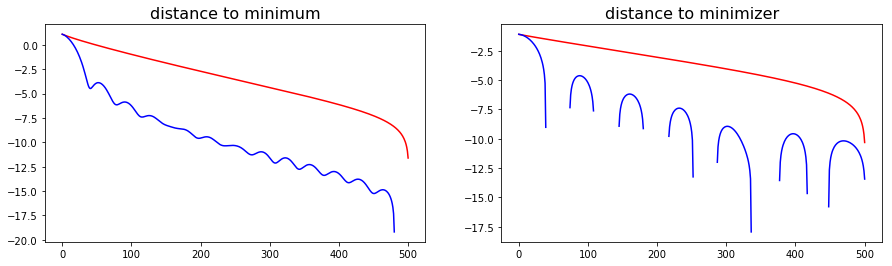

In [196]:
plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 2, 1)
plt.plot(np.log(obj_ista - obj_ista[-1]), 'r') 
plt.plot(np.log(obj_fista - obj_fista[-1]), 'b') 
plt.title("distance to minimum", fontsize=16)

plt.subplot(1, 2, 2)
plt.plot(np.log(errs_ista - errs_ista[-1]), 'r') 
plt.plot(np.log(errs_fista - errs_fista[-1]), 'b') 
plt.title("distance to minimizer", fontsize=16)

**Questions**

- In linear regression and logistic regression, study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.

- In linear regression and logistic regression, study the influence of the level of ridge 
  penalization on the performance of the optimization algorithms. Explain.

- In linear regression and logistic regression, compare the performance of the optimization
  algorithms for ridge and lasso penalizations. Explain

## YOUR ANSWER HERE

D:\Aanaconda\lib\site-packages\ipykernel\__main__.py:16: RuntimeWarning: divide by zero encountered in log
D:\Aanaconda\lib\site-packages\ipykernel\__main__.py:16: RuntimeWarning: invalid value encountered in log


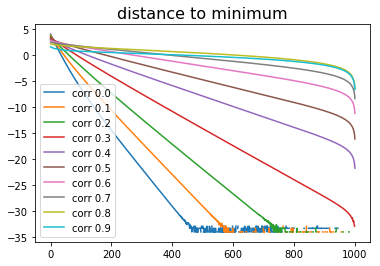

In [220]:
#study the influence of the correlation of the features
#on the performance of the optimization algorithms
#linear regression
##take ista as an example
#log(distance to minimum)
for i in range(10):
    A,b = simu_linreg(coefs, n_samples=1000, corr = 0.1*i)
    x0 = np.zeros(n_features)
    n_iter = 1000
    s = 1e-2
    L = lip_linreg(A)
    x_ista, obj_ista, errs_ista = ista(x0=x0, f=loss_linreg, grad_f=grad_linreg, g=ridge,
                                  prox_g=prox_ridge, step=1/L, s=s, n_iter=n_iter,
                                  x_true=coefs, verbose=False)

    plt.plot(np.log(obj_ista - obj_ista[-1]), label="corr %s" % (i/10)) 
    plt.legend()
    plt.title("distance to minimum", fontsize=16)

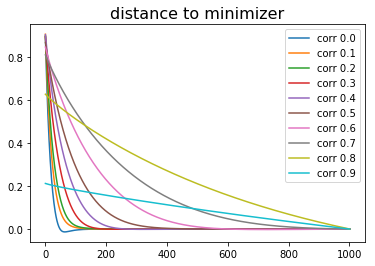

In [219]:
#distance to minimizer
#y is in normal scale, not log scale
for i in range(10):
    A,b = simu_linreg(coefs, n_samples=1000, corr = 0.1*i)
    x0 = np.zeros(n_features)
    n_iter = 1000
    s = 1e-2
    L = lip_linreg(A)
    x_ista, obj_ista, errs_ista = ista(x0=x0, f=loss_linreg, grad_f=grad_linreg, g=ridge,
                                  prox_g=prox_ridge, step=1/L, s=s, n_iter=n_iter,
                                  x_true=coefs, verbose=False)
    
    plt.plot(errs_ista - errs_ista[-1], label="corr %s" % (i/10)) 
    plt.legend()
    plt.title("distance to minimizer", fontsize=16)

D:\Aanaconda\lib\site-packages\ipykernel\__main__.py:16: RuntimeWarning: divide by zero encountered in log


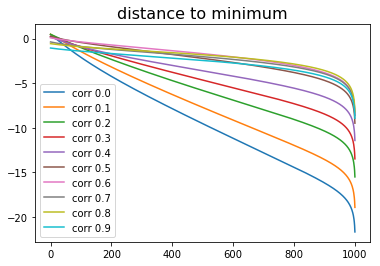

In [221]:
#study the influence of the correlation of the features
#on the performance of the optimization algorithms
#logistic regression
##take ista as an example
#log(distance to minimum)
for i in range(10):
    A,b = simu_logreg(coefs, n_samples=1000, corr = 0.1*i)
    x0 = np.zeros(n_features)
    n_iter = 1000
    s = 1e-2
    L = lip_logreg(A)
    x_ista, obj_ista, errs_ista = ista(x0=x0, f=loss_logreg, grad_f=grad_logreg, g=ridge,
                                  prox_g=prox_ridge, step=1/L, s=s, n_iter=n_iter,
                                  x_true=coefs, verbose=False)

    plt.plot(np.log(obj_ista - obj_ista[-1]), label="corr %s" % (i/10)) 
    plt.legend()
    plt.title("distance to minimum", fontsize=16)

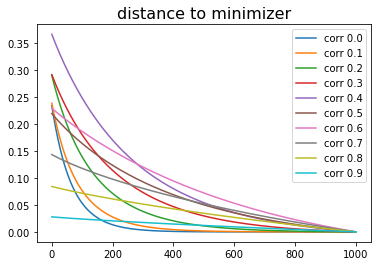

In [226]:
#distance to minimizer
#y is in normal scale, not log scale
for i in range(10):
    A,b = simu_logreg(coefs, n_samples=1000, corr = 0.1*i)
    x0 = np.zeros(n_features)
    n_iter = 1000
    s = 1e-2
    L = lip_linreg(A)
    x_ista, obj_ista, errs_ista = ista(x0=x0, f=loss_logreg, grad_f=grad_logreg, g=ridge,
                                  prox_g=prox_ridge, step=1/L, s=s, n_iter=n_iter,
                                  x_true=coefs, verbose=False)
    
    plt.plot(errs_ista - errs_ista[-1], label="corr %s" % (i/10)) 
    plt.legend()
    plt.title("distance to minimizer", fontsize=16)

Smaller correlation represents weaker dependance between every two features, thus A is closer to an identity matrix. Correspondantly the optimisation problem is easier. This is why it takes more iterations for ista's convergence as corr increases.

D:\Aanaconda\lib\site-packages\ipykernel\__main__.py:16: RuntimeWarning: divide by zero encountered in log


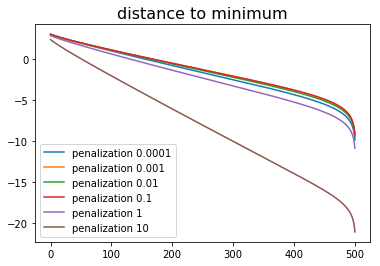

In [227]:
#study the influence of the level of ridge penalization on the performance of the optimization algorithms
##linear regression
##take ista as an example

#log(distance to minimum)
s_range = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
for s in s_range:
    A,b = simu_linreg(coefs, n_samples=1000, corr = 0.5)
    x0 = np.zeros(n_features)
    n_iter = 500
    L = lip_linreg(A)
    x_ista, obj_ista, errs_ista = ista(x0=x0, f=loss_linreg, grad_f=grad_linreg, g=ridge,
                                  prox_g=prox_ridge, step=1/L, s=s, n_iter=n_iter,
                                  x_true=coefs, verbose=False)

    plt.plot(np.log(obj_ista - obj_ista[-1]), label="penalization %s" % (s)) 
    plt.legend()
    plt.title("distance to minimum", fontsize=16)

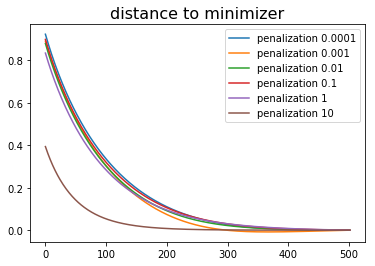

In [228]:
#distance to minimizer
#y is in normal scale, not log scale
for s in s_range:
    A,b = simu_linreg(coefs, n_samples=1000, corr = 0.5)
    x0 = np.zeros(n_features)
    n_iter = 500
    L = lip_linreg(A)
    x_ista, obj_ista, errs_ista = ista(x0=x0, f=loss_linreg, grad_f=grad_linreg, g=ridge,
                                  prox_g=prox_ridge, step=1/L, s=s, n_iter=n_iter,
                                  x_true=coefs, verbose=False)
    
    plt.plot(errs_ista - errs_ista[-1], label="penalization %s" % (s)) 
    plt.legend()
    plt.title("distance to minimizer", fontsize=16)

D:\Aanaconda\lib\site-packages\ipykernel\__main__.py:16: RuntimeWarning: divide by zero encountered in log


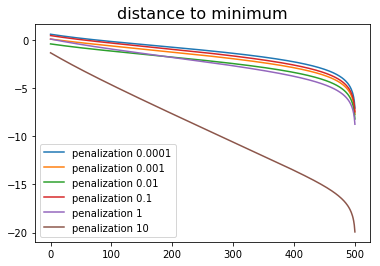

In [230]:
#study the influence of the level of ridge penalization on the performance of the optimization algorithms
##logistic regression
##take ista as an example

#log(distance to minimum)
s_range = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
for s in s_range:
    A,b = simu_logreg(coefs, n_samples=1000, corr = 0.5)
    x0 = np.zeros(n_features)
    n_iter = 500
    L = lip_logreg(A)
    x_ista, obj_ista, errs_ista = ista(x0=x0, f=loss_logreg, grad_f=grad_logreg, g=ridge,
                                  prox_g=prox_ridge, step=1/L, s=s, n_iter=n_iter,
                                  x_true=coefs, verbose=False)

    plt.plot(np.log(obj_ista - obj_ista[-1]), label="penalization %s" % (s)) 
    plt.legend()
    plt.title("distance to minimum", fontsize=16)

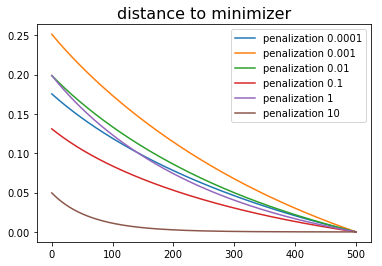

In [231]:
#distance to minimizer
#y is in normal scale, not log scale
for s in s_range:
    A,b = simu_logreg(coefs, n_samples=1000, corr = 0.5)
    x0 = np.zeros(n_features)
    n_iter = 500
    L = lip_logreg(A)
    x_ista, obj_ista, errs_ista = ista(x0=x0, f=loss_logreg, grad_f=grad_logreg, g=ridge,
                                  prox_g=prox_ridge, step=1/L, s=s, n_iter=n_iter,
                                  x_true=coefs, verbose=False)
    
    plt.plot(errs_ista - errs_ista[-1], label="penalization %s" % (s)) 
    plt.legend()
    plt.title("distance to minimizer", fontsize=16)

Different levels of penalization have different performances. This is clearer in the case of logistic regression. However no definite tendence can be derived as the penalization increases. For every iteration, there is an optimal step which minimize the objective function in this iteration.
By changing the level of penalization, the step of iteration changes, thus the performance depends on how close this step is to the optimal step.

In [263]:
#compare the performance of the optimization algorithms for ridge and lasso penalizations
#linear regression

A,b = simu_linreg(coefs, n_samples=1000, corr=0.5)
x0 = np.zeros(n_features)
n_iter = 1000
s = 1e-2
L = lip_linreg(A)
x_ridge, obj_ridge, errs_ridge = ista(x0=x0, f=loss_linreg, grad_f=grad_linreg, g=ridge,
                                  prox_g=prox_ridge, step=1/L, s=s, n_iter=n_iter,
                                  x_true=coefs, verbose=False)
x_lasso, obj_lasso, errs_lasso = ista(x0=x0, f=loss_linreg, grad_f=grad_linreg, g=lasso,
                                  prox_g=prox_lasso, step=1/L, s=s, n_iter=n_iter,
                                  x_true=coefs, verbose=False)

D:\Aanaconda\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: divide by zero encountered in log
D:\Aanaconda\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: invalid value encountered in subtract
D:\Aanaconda\lib\site-packages\ipykernel\__main__.py:11: RuntimeWarning: divide by zero encountered in log
D:\Aanaconda\lib\site-packages\ipykernel\__main__.py:11: RuntimeWarning: invalid value encountered in log
D:\Aanaconda\lib\site-packages\ipykernel\__main__.py:11: RuntimeWarning: invalid value encountered in subtract


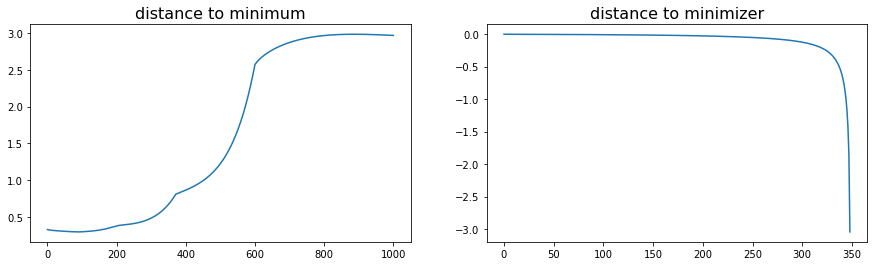

In [266]:
plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 2, 1)
dif_distance_obj = np.log(obj_ridge - obj_ridge[-1])-np.log(obj_lasso - obj_lasso[-1])
plt.plot(100*dif_distance_obj)
plt.title("distance to minimum", fontsize=16)



plt.subplot(1, 2, 2)
dif_distance_errs = np.log(errs_ridge - errs_ridge[-1])-np.log(errs_lasso - errs_lasso[-1])
plt.plot(dif_distance_errs)
plt.title("distance to minimizer", fontsize=16)

Define dif_distance_obj and dif_distance_errs as two indicators to compare the performances. dif_distance_errs is always inferior to 0, which means ridge penalization converges faster than lasso penalization.

In [267]:
#compare the performance of the optimization algorithms for ridge and lasso penalizations
#lpgistic regression

A,b = simu_logreg(coefs, n_samples=1000, corr=0.5)
x0 = np.zeros(n_features)
n_iter = 1000
s = 1e-2
L = lip_logreg(A)
x_ridge, obj_ridge, errs_ridge = ista(x0=x0, f=loss_logreg, grad_f=grad_logreg, g=ridge,
                                  prox_g=prox_ridge, step=1/L, s=s, n_iter=n_iter,
                                  x_true=coefs, verbose=False)
x_lasso, obj_lasso, errs_lasso = ista(x0=x0, f=loss_logreg, grad_f=grad_logreg, g=lasso,
                                  prox_g=prox_lasso, step=1/L, s=s, n_iter=n_iter,
                                  x_true=coefs, verbose=False)

D:\Aanaconda\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
D:\Aanaconda\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in subtract
  app.launch_new_instance()
D:\Aanaconda\lib\site-packages\ipykernel\__main__.py:10: RuntimeWarning: divide by zero encountered in log
D:\Aanaconda\lib\site-packages\ipykernel\__main__.py:10: RuntimeWarning: invalid value encountered in subtract


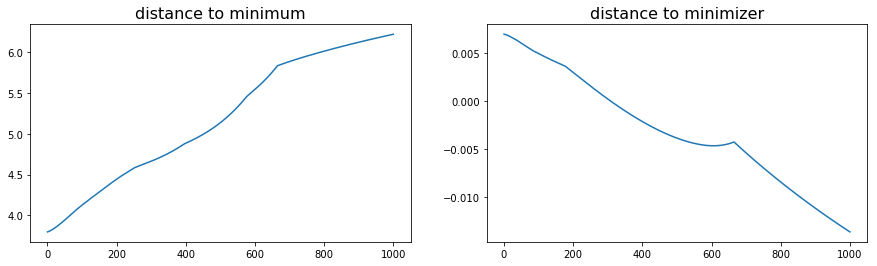

In [268]:
plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 2, 1)
dif_distance_obj = np.log(obj_ridge - obj_ridge[-1])-np.log(obj_lasso - obj_lasso[-1])
plt.plot(100*dif_distance_obj)
plt.title("distance to minimum", fontsize=16)



plt.subplot(1, 2, 2)
dif_distance_errs = np.log(errs_ridge - errs_ridge[-1])-np.log(errs_lasso - errs_lasso[-1])
plt.plot(dif_distance_errs)
plt.title("distance to minimizer", fontsize=16)

In the case of logistic regression, the dif_distance_errs is inferior to 0 after 300 iterations. This
means ridge penalization converges faster too.